In [27]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geopy.distance
import networkx as nx
import numpy as np
import community.community_louvain
import matplotlib.cm as cm
import collections

years = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
dataframes_OD = {}
dataframes_Stations = {}
df_concat_OD = pd.DataFrame()
df_concat_Stations = pd.DataFrame()
'''!!!!!!!!!!!!!!!!!!!!!!!!!
    Filepath export on my local Machine, please comment it out and 
    unzip files in ../data on your machine.
    !!!!!!!!!!!!!!!!!!!!!!!
'''
filepath_export = "../../../Local_BIXI/scripts"

for yr in years:
    dataframes_OD[yr] = pd.read_csv("{}/../data/BixiMontrealRentals{}/OD_{}.csv".format(filepath_export, yr, yr), low_memory=False)
    dataframes_Stations[yr] = pd.read_csv("{}/../data/BixiMontrealRentals{}/Stations_{}.csv".format(filepath_export, yr, yr), low_memory=False)
    if len(dataframes_OD and dataframes_Stations)==1:
        df_concat_OD = dataframes_OD[yr]
        df_concat_Stations = dataframes_Stations[yr]
    elif len(dataframes_OD and dataframes_Stations)>1:
        df_concat_OD = pd.concat([df_concat_OD, dataframes_OD[yr]], sort=False)
        df_concat_Stations = pd.concat([df_concat_Stations, dataframes_Stations[yr]], sort=False)
    else:
        print('Error!')
        break
#convert start_date and end_date to datetime objects
df_concat_OD[['start_date','end_date']] =  df_concat_OD[['start_date','end_date']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M')


In [48]:
temp=df_concat_OD.copy()
temp['start_station_code']=pd.to_numeric(temp['start_station_code'], errors='coerce')
temp['end_station_code']=pd.to_numeric(temp['end_station_code'], errors='coerce')
temp.dropna(inplace=True)
temp['start_station_code']=temp['start_station_code'].astype(np.int64)
temp['end_station_code']=temp['end_station_code'].astype(np.int64)
df_concat_OD = temp.copy()

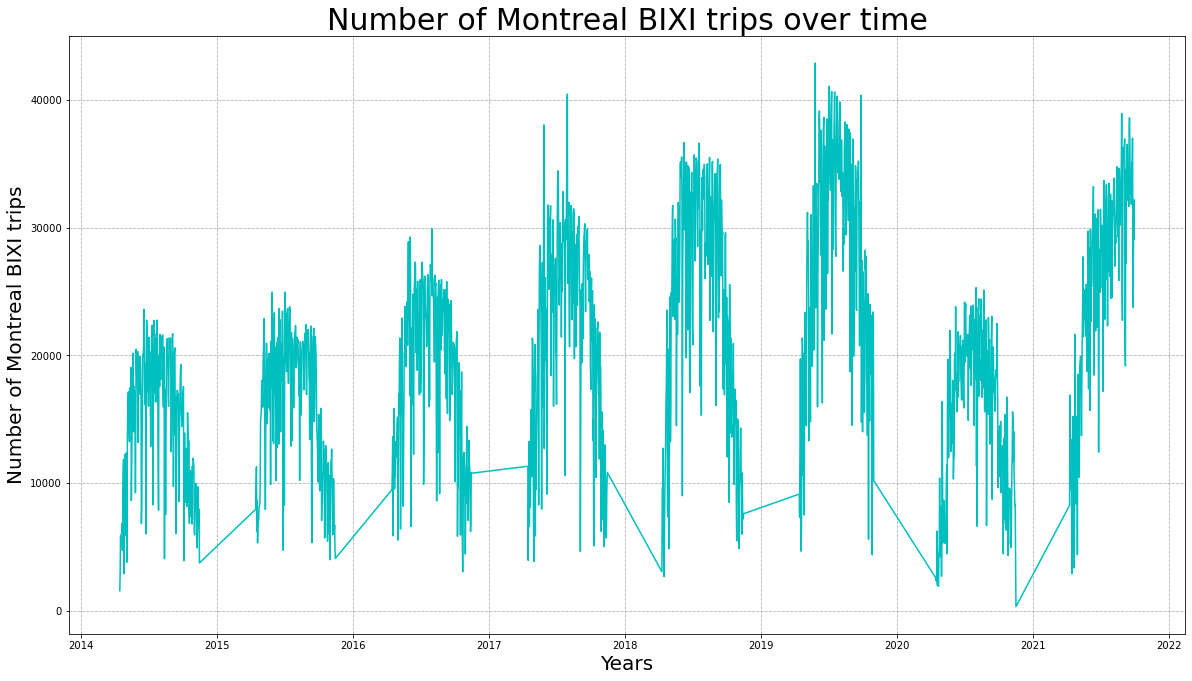

In [71]:
def plot_yearly_trips(data):    
    df = data.copy()
    yearly_df = df.groupby(df['start_date'].dt.date).size().reset_index(name='count')
    #Initialize a figure and plot on the canvas
    fig, ax = plt.subplots(figsize=(20,11))
    ax.set_title("Number of Montreal BIXI trips over time", fontsize= 30)
    ax.set_ylabel("Number of Montreal BIXI trips", fontsize= 20)
    ax.set_xlabel("Years", fontsize= 20)
    plt.plot(yearly_df['start_date'], yearly_df["count"], color= 'c')
    plt.grid(linestyle="--")
    #Save plot first
    fig.savefig("../plots/trips_over_time.png", format="png")
    plt.show()
plot_yearly_trips(df_concat_OD)    

In [52]:
def create_graph(data_OD, data_Stations, year):
    df = data_OD.copy()
    df = df[df['start_date'].dt.year == year]
    df_Stations = data_Stations.copy()  
    df_Stations = df_Stations[df_Stations['year'] == year]
    stations_names={k:v for k,v in list(zip(list(df_Stations['code']), 
                                       list(df_Stations['name'])))}
    
    #Get the latitude and longitude of trips start_date and end date
    df_start = df[['start_station_code']]
    df_start=df_start.rename({'start_station_code':'code'}, axis=1)
    df_start=df_start.merge(df_Stations[['code','latitude','longitude']], on='code')
    df['start_latitude']=df_start['latitude']
    df['start_longitude']=df_start['longitude']
    
    df_end = df[['end_station_code']]
    df_end=df_end.rename({'end_station_code':'code'}, axis=1)
    df_end=df_end.merge(df_Stations[['code','latitude','longitude']], on='code')
    df['end_latitude']=df_end['latitude']
    df['end_longitude']=df_end['longitude']
    
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
        
    #Get the distance between trip start and end in meters
    for i in list(df.index):
        start = (df.at[i,'start_latitude'], df.at[i,'start_longitude'])
        end = (df.at[i,'end_latitude'], df.at[i,'end_longitude'])
        df.at[i,'distance']=geopy.distance.geodesic(start, end).m
    
    df.dropna(inplace=True)
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df, 'start_station_code', 'end_station_code', edge_attr=['duration_sec','distance'])

    return G, stations_names


In [53]:
G, stations_names = create_graph(df_concat_OD, df_concat_Stations, 2019)


In [57]:
G.remove_edges_from(list(nx.selfloop_edges(G)))

In [60]:
def centrality_measures(G, stations_names, top_n=5):
    #Print the Graph general info.
    print("BIXI Montreal Network Description: \n",nx.info(G))
    print("Network density: {}\n".format(nx.density(G)))
    
    #Compute the degree centrality
    degree_centr=dict(G.degree(G.nodes()))
    temp=dict(sorted(degree_centr.items(), key=lambda x: x[1], reverse=True)[:top_n])
    top5_degree={stations_names[k]:v for k,v in temp.items()}
    
    print("Top {} nodes by degree centrality:\n".format(top_n))
    for item in top5_degree.items():
        print(item)
    
    #Compute the betweenness centrality
    betweenness_centr = nx.betweenness_centrality(G)
    temp = dict(sorted(betweenness_centr.items(), key=lambda x: x[1], reverse=True)[:top_n])
    top5_betweenness={stations_names[k]:v for k,v in temp.items()}
    

    print("\nTop {} nodes by betweeness centrality:\n".format(top_n))
    for item in top5_betweenness.items():
        print(item)
        
    #Compute the eigenvalue centrality
    eigen_centr = nx.eigenvector_centrality(G)
    temp=dict(sorted(eigen_centr.items(), key=lambda x: x[1], reverse=True)[:top_n])
    top5_eigenvector={stations_names[k]:v for k,v in temp.items()}
    
    print("\nTop {} nodes by eigenvector centrality:\n".format(top_n))
    for item in top5_eigenvector.items():
        print(item)

centrality_measures(G, stations_names)

BIXI Montreal Network Description: 
 Graph with 621 nodes and 127550 edges
Network density: 0.6625629837411043

Top 5 nodes by degree centrality:

('BAnQ (Berri / de Maisonneuve)', 588)
('Métro St-Laurent (de Maisonneuve / St-Laurent)', 573)
('du Président-Kennedy / Jeanne-Mance', 567)
('Métro Mont-Royal (Rivard / du Mont-Royal)', 566)
('de Maisonneuve / Aylmer (ouest)', 566)

Top 5 nodes by betweeness centrality:

('de la Commune / Berri', 0.002659594122694578)
('Roy / St-Laurent', 0.0023334509931410684)
('Legendre / Henri-Julien', 0.002131135237867565)
('BAnQ (Berri / de Maisonneuve)', 0.0020425378934268846)
('Métro St-Laurent (de Maisonneuve / St-Laurent)', 0.0020105492478233985)

Top 5 nodes by eigenvector centrality:

('BAnQ (Berri / de Maisonneuve)', 0.05187488148631091)
('Métro St-Laurent (de Maisonneuve / St-Laurent)', 0.05125643525779945)
('de Maisonneuve / Aylmer (ouest)', 0.05100062330060566)
('du Président-Kennedy / Jeanne-Mance', 0.05096354391985073)
('Métro Mont-Royal (Ri

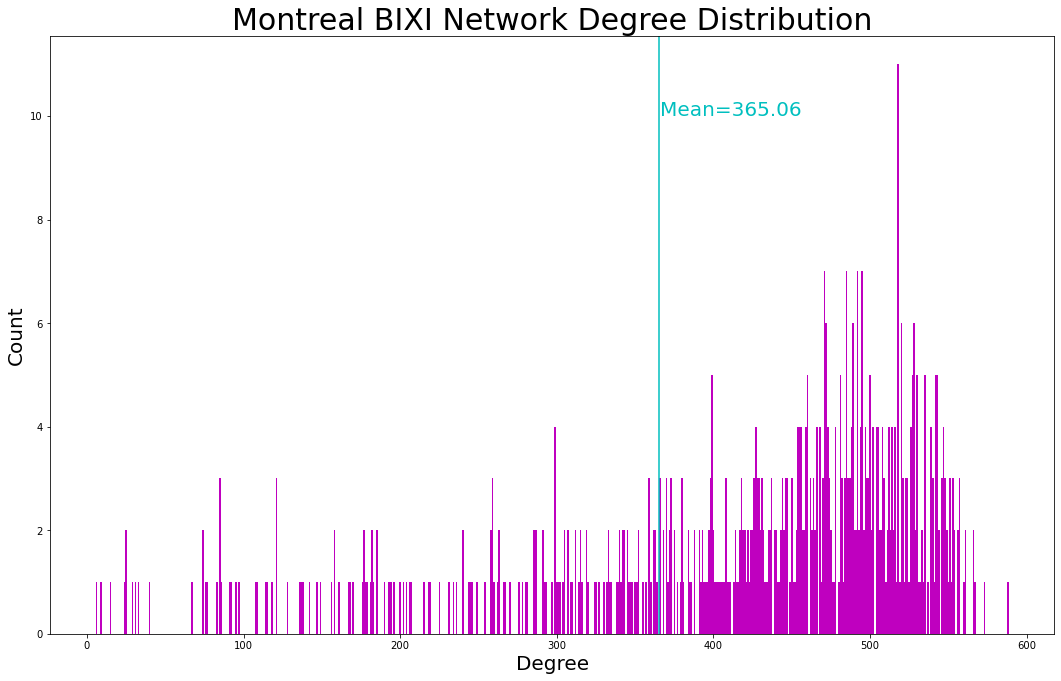

In [69]:
def degree_centrality_dist(G):
    
    #Compute the degree centrality
    degree_centr=dict(G.degree(G.nodes()))
    count_degrees = collections.Counter(list(degree_centr.values()))
    fig, ax = plt.subplots(figsize=(18,11))
    ax.set_title("Montreal BIXI Network Degree Distribution", fontsize= 30)
    ax.set_xlabel("Degree", fontsize= 20)
    ax.set_ylabel("Count", fontsize= 20)
    #Use barplot to show the degree distribution
    plt.bar(list(count_degrees.keys()), list(count_degrees.values()), width=1, color='m')
    #Add to the plot a vertical line representing the mean
    plt.axvline(x = np.mean(list(count_degrees.keys())), color='c')    
    plt.text(x= np.mean(list(count_degrees.keys()))+1,y=10, s="Mean={:.2f}".format(np.mean(list(count_degrees.keys()))), color = 'c', fontsize= 20)
    
    #Save plot first
    fig.savefig("../plots/degree_centrality_dist.png", format="png")

    plt.show()
    
degree_centrality_dist(G)

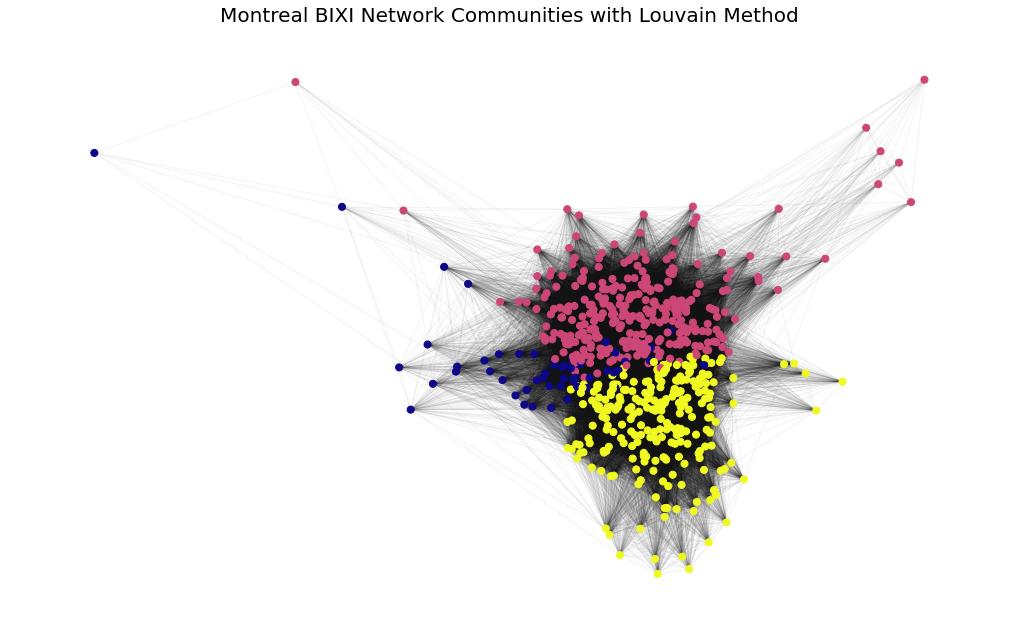

In [99]:
def community_louvain(G):
    #Get partition with Louvain
    partition = community.community_louvain.best_partition(G)    
    fig, ax = plt.subplots(figsize=(18,11))
    ax.set_title('Montreal BIXI Network Communities with Louvain Method', fontsize=20)
    cmap = cm.get_cmap('plasma', max(partition.values()) + 1)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=50, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.05)
    #Remove axis
    ax.axis('off')
    
    #Save plot first
    fig.savefig("../plots/community_louvain.png", format="png")
    
    plt.show()
    
    
community_louvain(G)